In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
from IPython.core.display import display, HTML, Javascript
import music21
import json, random
import guitarpro
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, Conv1D, MaxPool1D
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import np_utils 
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [3]:
%run ../Utilities/Utilities.ipynb

In [4]:
%run ../Segmentation/Segmenter.ipynb

In [56]:
class sheet_generator:
    def __init__(self, note_model, string_model, segmentation_model=Segmenter(), bpm=None):
        # Load prediction models
        self.note_model = load_NN(note_model, verbose=0)
        self.string_model = load_NN(string_model, verbose=0)
        self.segmentation_model = segmentation_model
        
        # Set bpm
        self.bpm = bpm
        
        # Load string-notes correspondence
        self.note_table = pd.read_csv("../Data/Piano/Note_table.tsv", header=0, sep="\t")
        self.start_8 = self.note_table[self.note_table["Note"] == "E1"].index[0]
        self.start_7 = self.note_table[self.note_table["Note"] == "B1"].index[0]
        self.start_6 = self.note_table[self.note_table["Note"] == "E2"].index[0]
        self.start_5 = self.note_table[self.note_table["Note"] == "A2"].index[0]
        self.start_4 = self.note_table[self.note_table["Note"] == "D3"].index[0]
        self.start_3 = self.note_table[self.note_table["Note"] == "G3"].index[0]
        self.start_2 = self.note_table[self.note_table["Note"] == "B3"].index[0]
        self.start_1 = self.note_table[self.note_table["Note"] == "E4"].index[0]
        self.string_notes = {
            "8": self.note_table["Note"].iloc[self.start_8:self.start_8+25].values,
            "7": self.note_table["Note"].iloc[self.start_7:self.start_7+25].values,
            "6": self.note_table["Note"].iloc[self.start_6:self.start_6+25].values,
            "5": self.note_table["Note"].iloc[self.start_5:self.start_5+25].values,
            "4": self.note_table["Note"].iloc[self.start_4:self.start_4+25].values,
            "3": self.note_table["Note"].iloc[self.start_3:self.start_3+25].values,
            "2": self.note_table["Note"].iloc[self.start_2:self.start_2+25].values,
            "1": self.note_table["Note"].iloc[self.start_1:self.start_1+25].values
        }
    
    def note_extraction(self, wave, show_plots):
        onsets = list(map(int, self.segmentation_model.predict(wave, show_plots)))
        
        # For now we add the end of file as an extra onset
        onsets.append(len(wave.y))
        results = []
        
        for i in tqdm(range(len(onsets) - 1), leave=False):
            note = waveform(wave.y[onsets[i]:onsets[i+1]])
            
            if len(note.y) >= 500:
                note_pred = librosa.midi_to_note(np.argmax(self.note_model.predict(note.temp_data(500))) + 28)

                # Run the string prediction over chunks of the entire note to get a more accurate prediction
                string_predictions = np.array(note.apply_window(500, 100, self.string_model.predict, True, False, True))[:,1]
                string_pred = int(np.median(np.array([np.argmax(x) for x in string_predictions])) + 1)
                duration = len(note.y) / 8000
                fret = self.find_fret(note_pred, string_pred)
                results.append([note_pred, string_pred, duration, fret])
        
        return results
    
    def find_fret(self, note, string):
        return np.argwhere(self.string_notes[str(string)] == note)[0][0]
    
    def bpm_estimation(self, extracted_notes):
        extracted_notes = np.array(extracted_notes)
        return round_to_base(1/(2 * np.median(extracted_notes[:,2].astype(float))) * 60, 10)
    
    def raw_sheet(self, extracted_notes, apply_heuristics):
        extracted_notes = np.array(extracted_notes)
        
        if self.bpm is None:
            self.bpm = self.bpm_estimation(extracted_notes)
            
        extracted_notes[:,2] = round_to_base(extracted_notes[:,2].astype(float), 1/self.bpm * 60/4)
        extracted_notes = extracted_notes[extracted_notes[:,2].astype("float") > 0]
        
        if apply_heuristics:
            for i in range(1, extracted_notes.shape[0]):
                cond1 = abs(librosa.note_to_midi(extracted_notes[i-1,0]) - librosa.note_to_midi(extracted_notes[i,0])) < 4
                cond2 = extracted_notes[i-1,1] != extracted_notes[i,1]
                if cond1 and cond2:
                    extracted_notes[i,1] = extracted_notes[i-1,1]
                    extracted_notes[i,3] = self.find_fret(extracted_notes[i,0], extracted_notes[i,1])
        
        return extracted_notes
    
    def display_tablature(self, sheet):
        tab = ""
        for string in range(1, 7):
            tab += self.string_notes[str(string)][0][0] + "  "
            for note in sheet:
                if int(note[1]) == string:
                    tab += note[3]
                else:
                    tab += "-" * len(note[3])
                tab += "-"
            tab += "\n"
        print(tab)
        
    def create_guitarpro_tab(self, sheet):
        template = guitarpro.parse('blank.gp5')
        measure_list = template.tracks[0].measures
        del template.tracks[0].measures[0].voices[0].beats[0]
        bar_start = 0
        current_measure = 0
        
        for i in range(len(sheet)):
            if (self.bpm/60) * (sheet[bar_start:i+1,2].astype("float").sum()) <= 4:
                duration = guitarpro.Duration(value= int(round(4/((self.bpm/60) * (sheet[i,2].astype("float"))))))
                new_beat = guitarpro.Beat(template.tracks[0].measures[0].voices[0], duration=duration)
                new_note = guitarpro.Note(new_beat, value=int(sheet[i,3]), string=int(sheet[i,1]), 
                                          type=guitarpro.NoteType.normal)
                new_beat.notes.append(new_note)
                template.tracks[0].measures[current_measure].voices[0].beats.append(new_beat)
            else:
                if (self.bpm/60) * (sheet[bar_start:i,2].astype("float").sum()) == 4:
                    current_measure += 1
                    new_measure = guitarpro.Measure(template.tracks[0], header=template.tracks[0].measures[0].header)
                    duration = guitarpro.Duration(value= int(round(4/((self.bpm/60) * (sheet[i,2].astype("float"))))))
                    new_beat = guitarpro.Beat(template.tracks[0].measures[0].voices[0], duration=duration)
                    new_note = guitarpro.Note(new_beat, value=int(sheet[i,3]), string=int(sheet[i,1]), 
                                              type=guitarpro.NoteType.normal)
                    new_beat.notes.append(new_note)
                    new_measure.voices[0].beats.append(new_beat)
                    measure_list.append(new_measure)
                    bar_start = i
                else:
                    fitting_beats = 4 - (self.bpm/60) * (sheet[bar_start:i,2].astype("float").sum())
                    duration = guitarpro.Duration(value= int(round(4/fitting_beats)))
                    new_beat = guitarpro.Beat(template.tracks[0].measures[0].voices[0], duration=duration)
                    new_note = guitarpro.Note(new_beat, value=int(sheet[i,3]), string=int(sheet[i,1]), 
                                              type=guitarpro.NoteType.normal)
                    new_beat.notes.append(new_note)
                    template.tracks[0].measures[current_measure].voices[0].beats.append(new_beat)
                    
                    remaining_beats = (self.bpm/60) * (sheet[i,2].astype("float")) - fitting_beats
                    current_measure += 1
                    new_measure = guitarpro.Measure(template.tracks[0], header=template.tracks[0].measures[0].header)
                    duration = guitarpro.Duration(value= int(round(4/remaining_beats)))
                    new_beat = guitarpro.Beat(template.tracks[0].measures[0].voices[0], duration=duration)
                    new_note = guitarpro.Note(new_beat, value=int(sheet[i,3]), string=int(sheet[i,1]), 
                                              type=guitarpro.NoteType.tie)
                    new_beat.notes.append(new_note)
                    new_measure.voices[0].beats.append(new_beat)
                    measure_list.append(new_measure)
                    bar_start = i
                    
            print(i,duration.value, (self.bpm/60) * (sheet[i,2].astype("float")))
        
        guitarpro.write(template, 'final.gp5')
    
    def display_music_sheet(self, sheet, play_audio=False):
        stream1 = music21.stream.Stream()
        instrument = music21.instrument.ElectricGuitar()
        instrument.partName = "Guitar"
        stream1.append(instrument)
        
        for i in range(len(sheet)):
            current_note = music21.note.Note(sheet[i,0])
            current_note.quarterLength = (self.bpm/60) * (sheet[i,2].astype("float"))
            stream1.append(current_note)
        
        if play_audio:
            stream1.show("midi")
        
        fp = stream1.write('midi', fp='test.mid')
            
        self.showScore(stream1)
        
    def showScore(self, score):
        xml = open(score.write('musicxml')).read()
        self.showMusicXML(xml)
        
    def showMusicXML(self, xml):
        DIV_ID = "OSMD-div-"+str(random.randint(0,1000000))
        print("DIV_ID", DIV_ID)
        display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))

        print('xml length:', len(xml))

        script = """
        console.log("loadOSMD()");
        function loadOSMD() { 
            return new Promise(function(resolve, reject){

                if (window.opensheetmusicdisplay) {
                    console.log("already loaded")
                    return resolve(window.opensheetmusicdisplay)
                }
                console.log("loading osmd for the first time")
                // OSMD script has a 'define' call which conflicts with requirejs
                var _define = window.define // save the define object 
                window.define = undefined // now the loaded script will ignore requirejs
                var s = document.createElement( 'script' );
                s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.3.1/build/opensheetmusicdisplay.min.js" );
                //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
                s.onload=function(){
                    window.define = _define
                    console.log("loaded OSMD for the first time",opensheetmusicdisplay)
                    resolve(opensheetmusicdisplay);
                };
                document.body.appendChild( s ); // browser will try to load the new script tag
            }) 
        }
        loadOSMD().then((OSMD)=>{
            console.log("loaded OSMD",OSMD)
            var div_id = "{{DIV_ID}}";
                console.log(div_id)
            window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id);
            openSheetMusicDisplay
                .load({{data}})
                .then(
                  function() {
                    console.log("rendering data")
                    openSheetMusicDisplay.render();
                  }
                );
        })
        """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
        display(Javascript(script))
        return DIV_ID

In [57]:
SG = sheet_generator("../Single_note_models/Guitar/Guitar", "../Single_note_models/Guitar/Guitar_norm_string", bpm=120)

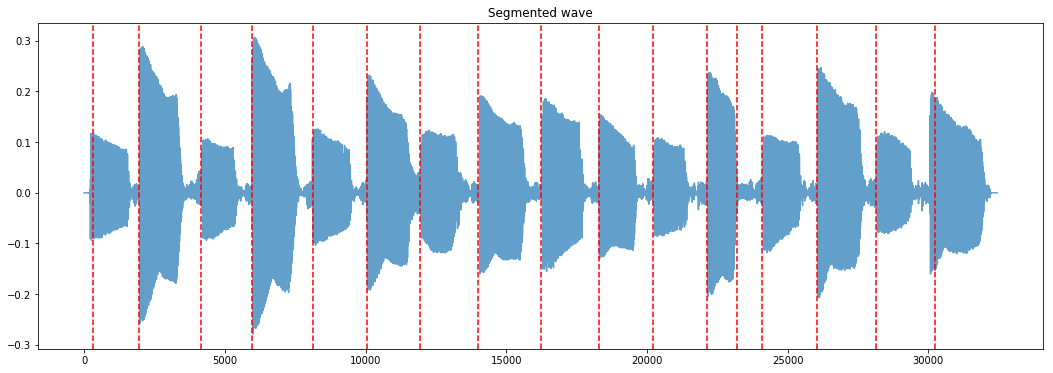

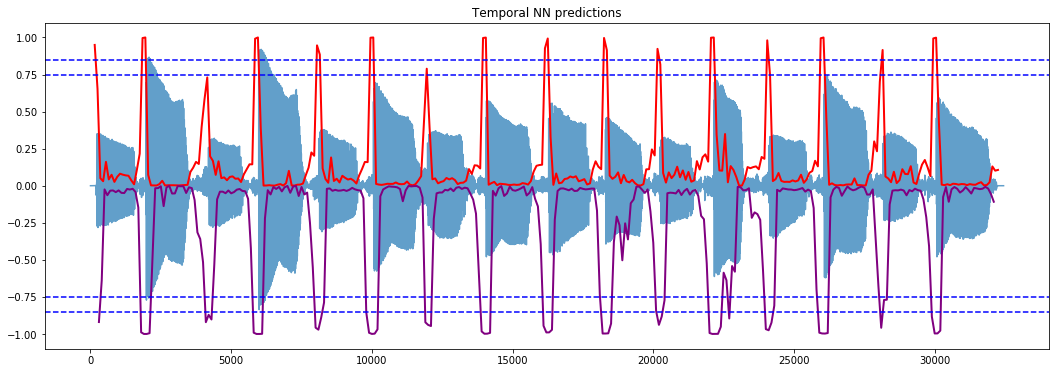

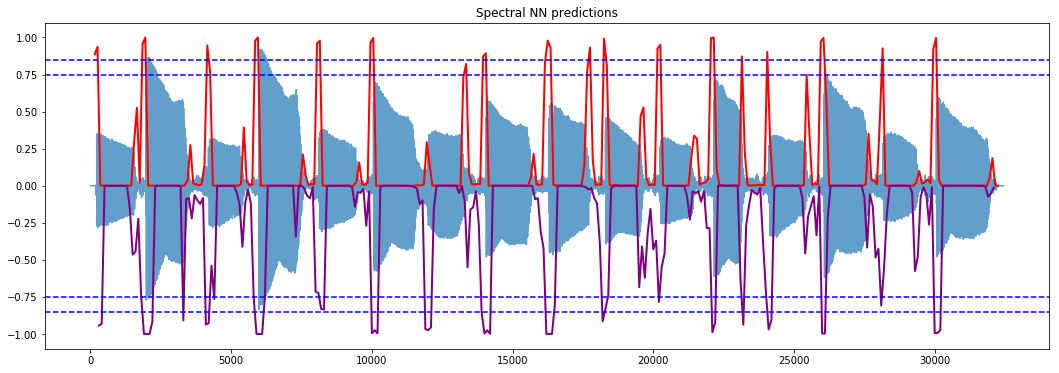

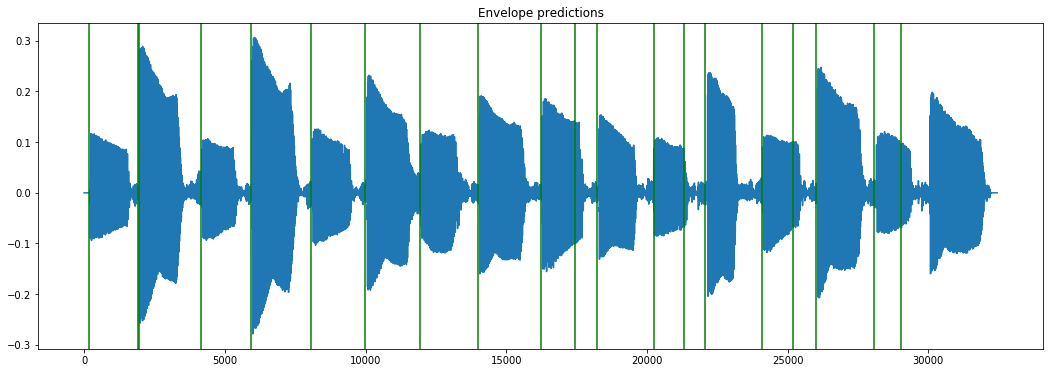

In [78]:
results = SG.note_extraction(waveform("../Samples/Guitar/Riffs/Guitar_noamp_riff2_1.mp3"), True)

In [79]:
results

[['G3', 5, 0.20625, 10],
 ['F#4', 3, 0.275, 11],
 ['G3', 5, 0.225, 10],
 ['F#4', 3, 0.275, 11],
 ['G3', 5, 0.2375, 10],
 ['G4', 3, 0.2375, 12],
 ['G3', 5, 0.25625, 10],
 ['F#4', 3, 0.28125, 11],
 ['G3', 5, 0.25625, 10],
 ['A4', 3, 0.2375, 14],
 ['G3', 5, 0.24375, 10],
 ['A4', 3, 0.13125, 14],
 ['G4', 4, 0.1125, 17],
 ['G3', 5, 0.24375, 10],
 ['E4', 3, 0.2625, 9],
 ['G3', 5, 0.2625, 10],
 ['E4', 3, 0.274875, 9]]

In [80]:
sheet = SG.raw_sheet(results, True)

In [81]:
SG.create_guitarpro_tab(sheet)

0 8 0.5
1 8 0.5
2 8 0.5
3 8 0.5
4 8 0.5
5 8 0.5
6 8 0.5
7 8 0.5
8 8 0.5
9 8 0.5
10 8 0.5
11 16 0.25
12 16 0.25
13 8 0.5
14 8 0.5
15 8 0.5
16 8 0.5


In [82]:
SG.display_tablature(sheet)

E  -------------------------------------------------
B  -------------------------------------------------
G  ---11----11----12----11----14----14-12----9----9-
D  -------------------------------------------------
A  10----10----10----10----10----10-------10---10---
E  -------------------------------------------------



In [83]:
SG.display_music_sheet(sheet)

DIV_ID OSMD-div-171046


xml length: 5760


<IPython.core.display.Javascript object>